Libraries imported successfully!
Brownian Motion function defined.


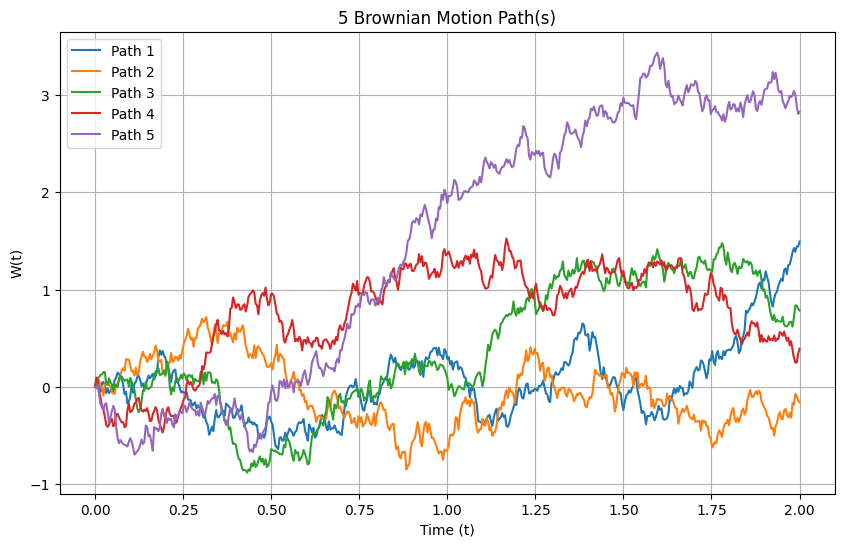

Shape of BM time vector t_bm: (501,)
Shape of BM paths W_bm: (501, 5)
First few values of W_bm[:, 0]:
[ 0.          0.03141496  0.01660684 -0.01270227 -0.04826445]
------------------------------
Geometric Brownian Motion function defined.


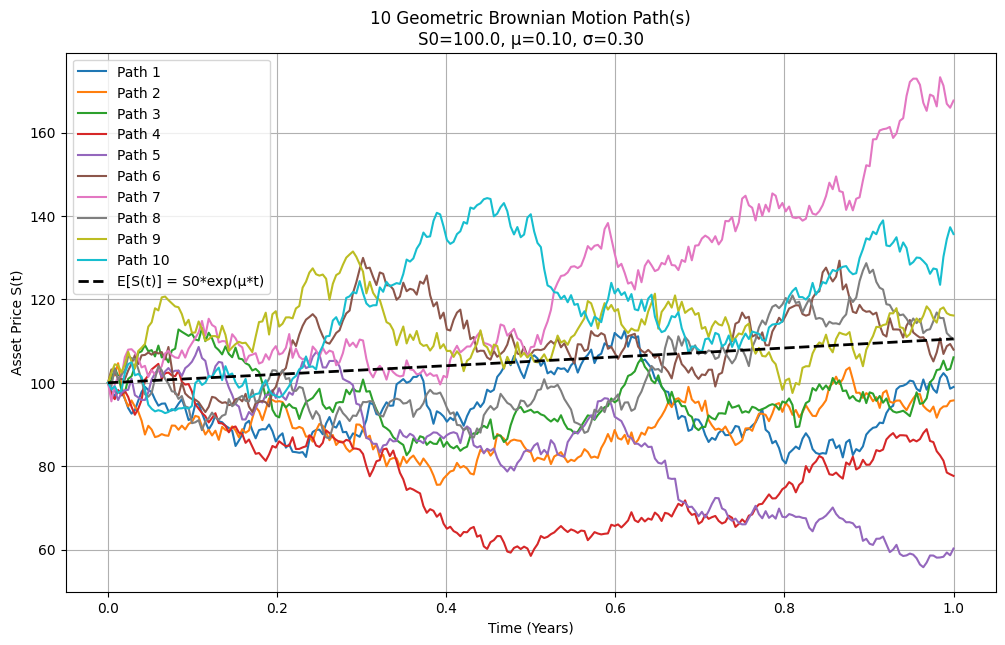

Shape of GBM time vector t_gbm: (253,)
Shape of GBM paths S_gbm: (253, 10)
Initial prices for GBM paths (S_gbm[0,:]): 
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]
Final prices for 10 GBM paths (S_gbm[-1,:]): 
[ 98.99  95.77 106.1   77.66  60.25 107.94 167.68 110.44 116.13 135.67]
------------------------------

--- Algorithmic Trading Considerations & Next Steps (Summary) ---

Applications in Algo Trading:
1. Monte Carlo Pricing: Valuing complex options.
2. Risk Management: Estimating VaR, CVaR.
3. Strategy Backtesting: Generating synthetic data to test strategy robustness.
4. Volatility Modeling: Basis for understanding implied volatility surfaces.
5. Path-Dependent Options: Essential for pricing options whose payoff depends on the asset's path.

Key Limitations of Basic GBM:
1. Constant Volatility: Real-world volatility is stochastic and clusters.
2. No Jumps: Real markets experience sudden price jumps.
3. Normal Log Returns: Real returns often have fat tails and skewness.
4.

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt

print("Libraries imported successfully!")

# --- Phase 3: Implementing Brownian Motion ---

# Step 3: Define the Brownian Motion Function
def generate_brownian_motion(T=1.0, N=100, num_paths=1, seed=None):
    """
    Generates Brownian Motion (Wiener Process) paths.

    Parameters:
    - T (float): Total time period (e.g., 1 year).
    - N (int): Number of time steps.
    - num_paths (int): Number of independent paths to generate.
    - seed (int, optional): Random seed for reproducibility.

    Returns:
    - t (numpy.ndarray): Time vector of shape (N+1,).
    - W (numpy.ndarray): Brownian Motion paths. Shape (N+1, num_paths).
                         Each column is a path, W[0,:] is W_0 = 0.
    """
    if seed is not None:
        np.random.seed(seed)

    dt = T / N  # Time step size
    t = np.linspace(0, T, N + 1) # Time vector (N+1 points to include t=0 and t=T)

    # Brownian increments (dW_t = Z * sqrt(dt))
    # Z ~ N(0,1)
    # We need N increments for N steps, for each path
    dW = np.random.normal(loc=0.0, scale=np.sqrt(dt), size=(N, num_paths))

    # Prepend zeros for W_0 = 0 for each path
    W0 = np.zeros((1, num_paths))
    dW_with_W0 = np.vstack([W0, dW]) # Shape: (N+1, num_paths)

    # Cumulatively sum the increments to get the BM path(s)
    # W_t = sum_{i=1 to t/dt} dW_i
    W = np.cumsum(dW_with_W0, axis=0)

    return t, W

print("Brownian Motion function defined.")

# Step 4: Generate and Plot Brownian Motion

# Parameters for BM
T_bm = 2.0         # Total time (e.g., 2 units of time)
N_bm = 500         # Number of steps
num_paths_bm = 5   # Number of paths to simulate
seed_bm = 42       # For reproducibility

# Generate BM paths
t_bm, W_bm = generate_brownian_motion(T=T_bm, N=N_bm, num_paths=num_paths_bm, seed=seed_bm)

# Plotting Brownian Motion
plt.figure(figsize=(10, 6))
for i in range(num_paths_bm):
    plt.plot(t_bm, W_bm[:, i], label=f'Path {i+1}' if num_paths_bm <= 5 else None) # Avoid too many labels

plt.title(f'{num_paths_bm} Brownian Motion Path(s)')
plt.xlabel('Time (t)')
plt.ylabel('W(t)')
plt.grid(True)
if num_paths_bm <= 5 and num_paths_bm > 1:
    plt.legend()
plt.show()

print(f"Shape of BM time vector t_bm: {t_bm.shape}")        # Expected: (N_bm+1,)
print(f"Shape of BM paths W_bm: {W_bm.shape}")            # Expected: (N_bm+1, num_paths_bm)
print(f"First few values of W_bm[:, 0]:\n{W_bm[:5, 0]}")  # W_0 should be 0
print("-" * 30)


# --- Phase 4: Implementing Geometric Brownian Motion ---

# Step 5: Define the Geometric Brownian Motion Function
def generate_gbm(S0=100.0, mu=0.05, sigma=0.2, T=1.0, N=100, num_paths=1, seed=None):
    """
    Generates Geometric Brownian Motion paths.
    S_t = S_0 * exp( (mu - 0.5*sigma^2)*t + sigma*W_t )
    or iteratively: S_{t+dt} = S_t * exp( (mu - 0.5*sigma^2)*dt + sigma*sqrt(dt)*Z )

    Parameters:
    - S0 (float): Initial asset price.
    - mu (float): Drift coefficient (annualized expected return).
    - sigma (float): Volatility coefficient (annualized standard deviation of returns).
    - T (float): Total time period (e.g., 1 year).
    - N (int): Number of time steps.
    - num_paths (int): Number of independent paths to generate.
    - seed (int, optional): Random seed for reproducibility.

    Returns:
    - t (numpy.ndarray): Time vector of shape (N+1,).
    - S (numpy.ndarray): GBM paths. Shape (N+1, num_paths).
                         Each column is a path, S[0,:] is S0.
    """
    if seed is not None:
        np.random.seed(seed)

    dt = T / N  # Time step size
    t = np.linspace(0, T, N + 1) # Time vector

    # Standard Normal random variables (Z ~ N(0,1))
    # We need N random variables for N steps, for each path
    Z = np.random.normal(loc=0.0, scale=1.0, size=(N, num_paths))

    # Initialize S array. S[0,:] is S0 for all paths.
    S = np.zeros((N + 1, num_paths))
    S[0, :] = S0

    # Calculate GBM paths step-by-step using the discrete solution
    # S_{t+dt} = S_t * exp( (μ - σ²/2) * dt + σ * sqrt(dt) * Z_t )
    for i in range(1, N + 1):
        drift_term = (mu - 0.5 * sigma**2) * dt
        # Z[i-1, :] corresponds to the random shock for the i-th step (from t_i-1 to t_i)
        diffusion_term = sigma * np.sqrt(dt) * Z[i-1, :]
        S[i, :] = S[i-1, :] * np.exp(drift_term + diffusion_term)

    return t, S

print("Geometric Brownian Motion function defined.")

# Step 6: Generate and Plot Geometric Brownian Motion

# Parameters for GBM
S0_gbm = 100.0     # Initial stock price
mu_gbm = 0.10      # Expected annual return (10%)
sigma_gbm = 0.30   # Annual volatility (30%)
T_gbm = 1.0        # Time horizon (1 year)
N_gbm = 252        # Number of trading days in a year (common choice for daily steps)
num_paths_gbm = 10 # Number of paths to simulate
seed_gbm = 123     # For reproducibility

# Generate GBM paths
t_gbm, S_gbm = generate_gbm(S0=S0_gbm, mu=mu_gbm, sigma=sigma_gbm,
                            T=T_gbm, N=N_gbm, num_paths=num_paths_gbm, seed=seed_gbm)

# Plotting Geometric Brownian Motion
plt.figure(figsize=(12, 7))
for i in range(num_paths_gbm):
    plt.plot(t_gbm, S_gbm[:, i], label=f'Path {i+1}' if num_paths_gbm <= 10 else None)

plt.title(f'{num_paths_gbm} Geometric Brownian Motion Path(s)\nS0={S0_gbm}, μ={mu_gbm:.2f}, σ={sigma_gbm:.2f}')
plt.xlabel('Time (Years)')
plt.ylabel('Asset Price S(t)')
plt.grid(True)
# Optional: Add a line for the theoretical expected value E[S_t] = S0 * exp(mu*t)
# Note: Individual paths can deviate significantly from this expectation.
plt.plot(t_gbm, S0_gbm * np.exp(mu_gbm * t_gbm), 'k--', lw=2, label=f'E[S(t)] = S0*exp(μ*t)')
if num_paths_gbm <= 10 :
    plt.legend()
plt.show()

print(f"Shape of GBM time vector t_gbm: {t_gbm.shape}")        # Expected: (N_gbm+1,)
print(f"Shape of GBM paths S_gbm: {S_gbm.shape}")            # Expected: (N_gbm+1, num_paths_gbm)
print(f"Initial prices for GBM paths (S_gbm[0,:]): \n{S_gbm[0, :]}") # Should be S0_gbm
print(f"Final prices for {num_paths_gbm} GBM paths (S_gbm[-1,:]): \n{np.round(S_gbm[-1, :], 2)}")
print("-" * 30)

# --- Phase 5: Algorithmic Trading Considerations & Next Steps (Summary) ---
print("\n--- Algorithmic Trading Considerations & Next Steps (Summary) ---")
print("""
Applications in Algo Trading:
1. Monte Carlo Pricing: Valuing complex options.
2. Risk Management: Estimating VaR, CVaR.
3. Strategy Backtesting: Generating synthetic data to test strategy robustness.
4. Volatility Modeling: Basis for understanding implied volatility surfaces.
5. Path-Dependent Options: Essential for pricing options whose payoff depends on the asset's path.

Key Limitations of Basic GBM:
1. Constant Volatility: Real-world volatility is stochastic and clusters.
2. No Jumps: Real markets experience sudden price jumps.
3. Normal Log Returns: Real returns often have fat tails and skewness.
4. No Memory/Microstructure: Ignores past prices beyond the current one and market microstructure.

Potential Enhancements:
1. Parameter Estimation: Estimate mu and sigma from historical data.
2. Correlated GBMs: Simulate multiple, correlated assets.
3. Advanced Models: Heston (stochastic vol), Jump-Diffusion, GARCH (time-varying vol).
""")